Original image size: 528x489
Cropped image size: 388x349
Original image size: 528x489
Cropped image size: 388x349
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x489
Cropped image size: 388x349
Original image size: 528x489
Cropped image size: 388x349
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x489
Cropped image size: 388x349
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x489
Cropped image size: 388x349
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x488
Cropped image size: 388x348
Original image size: 528x489
Cr

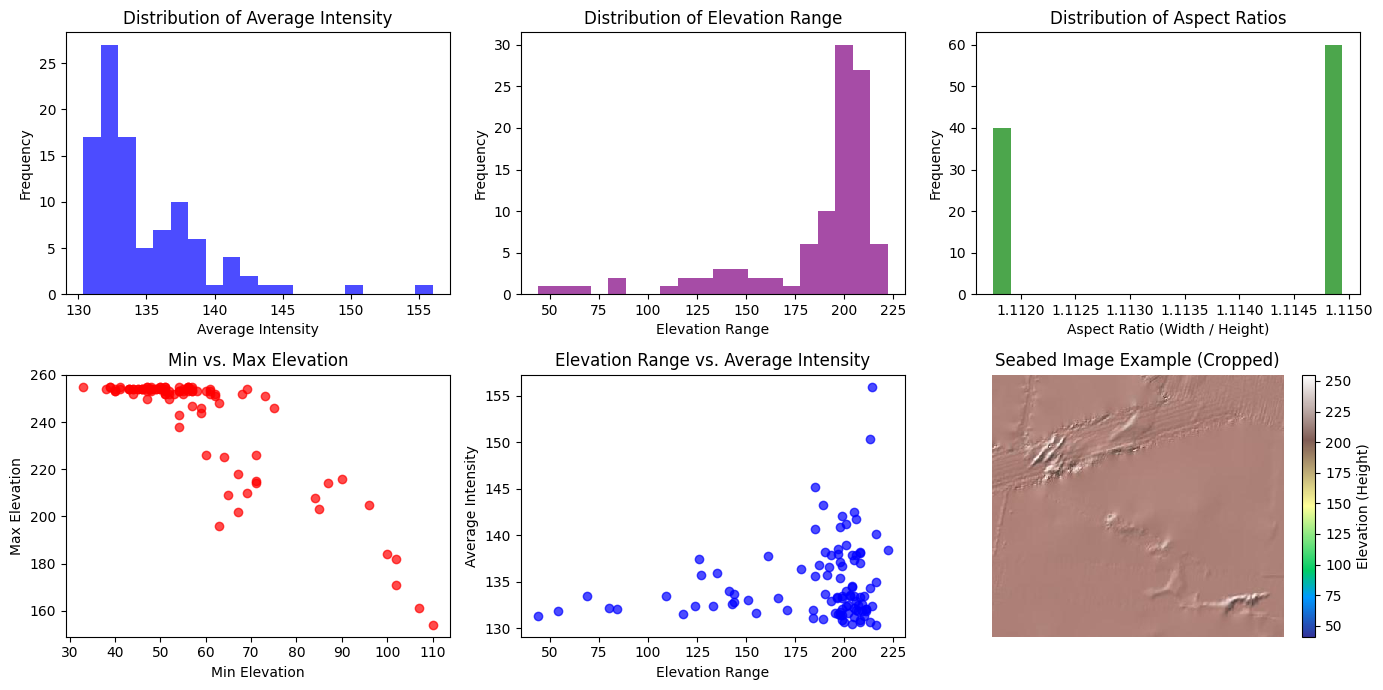

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Parameters
image_folder = "equal_tiles"  # Folder containing the images
output_csv = "image_statistics.csv"  # Save stats to a CSV file
crop_pixels = 70  # Number of pixels to crop from each border (top, bottom, left, right)

# Function to crop a fixed number of pixels from the borders
def crop_fixed_border(image, crop_pixels=5):
    height, width, _ = image.shape
    print(f"Original image size: {width}x{height}")  # Debugging line
    if height > crop_pixels * 2 and width > crop_pixels * 2:
        cropped_image = image[crop_pixels:height-crop_pixels, crop_pixels:width-crop_pixels]
        cropped_height, cropped_width, _ = cropped_image.shape
        print(f"Cropped image size: {cropped_width}x{cropped_height}")  # Debugging line
        return cropped_image
    else:
        print(f"Warning: Crop size too large for image {width}x{height}. Returning original image.")
        return image  # Return the original image if cropping is not possible

# Load images
image_paths = glob(os.path.join(image_folder, "*.png"))
if not image_paths:
    print("No images found in the specified folder.")
    exit()

# Data storage
data = []

# Loop through each image (this will ensure reprocessing every time)
for image_path in image_paths:
    try:
        # Reload and process image each time (ensures the crop_pixels change takes effect)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image {image_path} is corrupt or unreadable.")
            continue
        
        # Crop out fixed border
        cropped_image = crop_fixed_border(image, crop_pixels)
        height, width, channels = cropped_image.shape
        
        # Convert to grayscale
        grayscale = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        
        # Average and standard deviation of intensity
        avg_intensity = np.mean(grayscale)
        std_intensity = np.std(grayscale)
        
        # Elevation statistics (e.g., terrain variation)
        min_elevation = np.min(grayscale)
        max_elevation = np.max(grayscale)
        elevation_range = max_elevation - min_elevation

        # Color histograms (representing terrain height variations in color channels)
        color_hist_b = cv2.calcHist([cropped_image], [0], None, [256], [0, 256])  # Blue channel
        color_hist_g = cv2.calcHist([cropped_image], [1], None, [256], [0, 256])  # Green channel
        color_hist_r = cv2.calcHist([cropped_image], [2], None, [256], [0, 256])  # Red channel

        # Store data
        data.append({
            "file_name": os.path.basename(image_path),
            "width": width,
            "height": height,
            "avg_intensity": avg_intensity,
            "std_intensity": std_intensity,
            "min_elevation": min_elevation,
            "max_elevation": max_elevation,
            "elevation_range": elevation_range,
            "aspect_ratio": width / height,
        })

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Create a DataFrame for analysis
df = pd.DataFrame(data)

# Save to CSV
df.to_csv(output_csv, index=False)
print(f"Statistics saved to {output_csv}")

# Display some EDA results
print(df.describe())

# Visualization: Histograms of intensity and aspect ratios
plt.figure(figsize=(14, 7))

# Average intensity distribution
plt.subplot(2, 3, 1)
plt.hist(df["avg_intensity"], bins=20, color="blue", alpha=0.7)
plt.title("Distribution of Average Intensity")
plt.xlabel("Average Intensity")
plt.ylabel("Frequency")

# Elevation range distribution
plt.subplot(2, 3, 2)
plt.hist(df["elevation_range"], bins=20, color="purple", alpha=0.7)
plt.title("Distribution of Elevation Range")
plt.xlabel("Elevation Range")
plt.ylabel("Frequency")

# Aspect ratio distribution
plt.subplot(2, 3, 3)
plt.hist(df["aspect_ratio"], bins=20, color="green", alpha=0.7)
plt.title("Distribution of Aspect Ratios")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")

# Min elevation vs. max elevation
plt.subplot(2, 3, 4)
plt.scatter(df["min_elevation"], df["max_elevation"], alpha=0.7, color="red")
plt.title("Min vs. Max Elevation")
plt.xlabel("Min Elevation")
plt.ylabel("Max Elevation")

# Elevation range vs. average intensity
plt.subplot(2, 3, 5)
plt.scatter(df["elevation_range"], df["avg_intensity"], alpha=0.7, color="blue")
plt.title("Elevation Range vs. Average Intensity")
plt.xlabel("Elevation Range")
plt.ylabel("Average Intensity")

# Heatmap for one cropped image (for better understanding of seabed texture)
image_example = cv2.imread(image_paths[0])
cropped_example = crop_fixed_border(image_example, crop_pixels)
plt.subplot(2, 3, 6)
plt.imshow(cropped_example, cmap='terrain', interpolation='nearest')
plt.title("Seabed Image Example (Cropped)")
plt.colorbar(label="Elevation (Height)")
plt.axis('off')

plt.tight_layout()
plt.show()
